In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm

torch.cuda.empty_cache()

In [2]:
path='/kaggle/working/Cherry'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!mkdir /kaggle/working/Cherry

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Cherry* /kaggle/working/Cherry
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Cherry* /kaggle/working/Cherry

transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])

dataset=ImageFolder(path,transform=transfrom)

train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*112*112, 2)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# iter = 0
# for epoch in range(int(num_epochs)):
#     for i, (images, labels) in enumerate(train_loader):
#         images = Variable(images.cuda())
#         labels = Variable(labels.cuda())
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         iter += 1
        
#         if iter % 500 == 0:
#             correct = 0
#             total = 0
#             for images, labels in test_loader:
#                 images = Variable(images.cuda())
#                 outputs = model(images)
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
                
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()
                
#             accuracy = 100 * correct / total
#             print('Iteration: {}. Loss {}. Accuracy: {}'.format(iter, loss.data, accuracy))

In [4]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [5]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [6]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=20
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 191/191 [00:10<00:00, 17.57it/s]


Train Loss: 0.727 | Accuracy: 66.093


100%|██████████| 48/48 [00:00<00:00, 60.50it/s]


Test Loss: 0.601 | Accuracy: 68.721

Epoch : 2


100%|██████████| 191/191 [00:04<00:00, 43.71it/s]


Train Loss: 0.581 | Accuracy: 72.864


100%|██████████| 48/48 [00:00<00:00, 61.97it/s]


Test Loss: 0.595 | Accuracy: 63.541

Epoch : 3


100%|██████████| 191/191 [00:04<00:00, 40.77it/s]


Train Loss: 0.499 | Accuracy: 76.554


100%|██████████| 48/48 [00:00<00:00, 59.68it/s]


Test Loss: 0.461 | Accuracy: 79.869

Epoch : 4


100%|██████████| 191/191 [00:04<00:00, 40.72it/s]


Train Loss: 0.429 | Accuracy: 80.210


100%|██████████| 48/48 [00:00<00:00, 60.41it/s]


Test Loss: 0.349 | Accuracy: 86.230

Epoch : 5


100%|██████████| 191/191 [00:04<00:00, 39.97it/s]


Train Loss: 0.398 | Accuracy: 83.046


100%|██████████| 48/48 [00:00<00:00, 56.03it/s]


Test Loss: 0.280 | Accuracy: 87.279

Epoch : 6


100%|██████████| 191/191 [00:04<00:00, 43.13it/s]


Train Loss: 0.325 | Accuracy: 86.572


100%|██████████| 48/48 [00:00<00:00, 66.39it/s]


Test Loss: 0.469 | Accuracy: 76.262

Epoch : 7


100%|██████████| 191/191 [00:04<00:00, 41.32it/s]


Train Loss: 0.342 | Accuracy: 86.358


100%|██████████| 48/48 [00:00<00:00, 64.39it/s]


Test Loss: 0.337 | Accuracy: 85.836

Epoch : 8


100%|██████████| 191/191 [00:04<00:00, 40.20it/s]


Train Loss: 0.335 | Accuracy: 86.424


100%|██████████| 48/48 [00:00<00:00, 62.59it/s]


Test Loss: 0.308 | Accuracy: 89.902

Epoch : 9


100%|██████████| 191/191 [00:04<00:00, 42.07it/s]


Train Loss: 0.284 | Accuracy: 88.719


100%|██████████| 48/48 [00:00<00:00, 63.85it/s]


Test Loss: 0.391 | Accuracy: 82.230

Epoch : 10


100%|██████████| 191/191 [00:04<00:00, 41.10it/s]


Train Loss: 0.283 | Accuracy: 88.326


100%|██████████| 48/48 [00:00<00:00, 65.36it/s]


Test Loss: 0.299 | Accuracy: 89.246

Epoch : 11


100%|██████████| 191/191 [00:04<00:00, 40.87it/s]


Train Loss: 0.308 | Accuracy: 88.375


100%|██████████| 48/48 [00:00<00:00, 62.66it/s]


Test Loss: 0.265 | Accuracy: 88.328

Epoch : 12


100%|██████████| 191/191 [00:04<00:00, 41.18it/s]


Train Loss: 0.261 | Accuracy: 89.375


100%|██████████| 48/48 [00:00<00:00, 66.05it/s]


Test Loss: 0.191 | Accuracy: 92.852

Epoch : 13


100%|██████████| 191/191 [00:04<00:00, 43.50it/s]


Train Loss: 0.190 | Accuracy: 92.655


100%|██████████| 48/48 [00:00<00:00, 69.89it/s]


Test Loss: 0.159 | Accuracy: 94.492

Epoch : 14


100%|██████████| 191/191 [00:04<00:00, 40.16it/s]


Train Loss: 0.144 | Accuracy: 94.950


100%|██████████| 48/48 [00:00<00:00, 66.42it/s]


Test Loss: 0.155 | Accuracy: 94.689

Epoch : 15


100%|██████████| 191/191 [00:04<00:00, 41.63it/s]


Train Loss: 0.292 | Accuracy: 87.457


100%|██████████| 48/48 [00:00<00:00, 66.62it/s]


Test Loss: 0.204 | Accuracy: 92.459

Epoch : 16


100%|██████████| 191/191 [00:04<00:00, 39.63it/s]


Train Loss: 0.163 | Accuracy: 93.737


100%|██████████| 48/48 [00:00<00:00, 60.65it/s]


Test Loss: 0.144 | Accuracy: 94.754

Epoch : 17


100%|██████████| 191/191 [00:04<00:00, 41.09it/s]


Train Loss: 0.145 | Accuracy: 94.327


100%|██████████| 48/48 [00:00<00:00, 63.40it/s]


Test Loss: 0.140 | Accuracy: 94.689

Epoch : 18


100%|██████████| 191/191 [00:04<00:00, 43.18it/s]


Train Loss: 0.129 | Accuracy: 95.048


100%|██████████| 48/48 [00:00<00:00, 67.76it/s]


Test Loss: 0.125 | Accuracy: 95.738

Epoch : 19


100%|██████████| 191/191 [00:04<00:00, 43.56it/s]


Train Loss: 0.131 | Accuracy: 95.130


100%|██████████| 48/48 [00:00<00:00, 63.73it/s]


Test Loss: 0.400 | Accuracy: 80.984

Epoch : 20


100%|██████████| 191/191 [00:04<00:00, 40.77it/s]


Train Loss: 0.230 | Accuracy: 91.031


100%|██████████| 48/48 [00:00<00:00, 66.20it/s]

Test Loss: 1.144 | Accuracy: 57.115


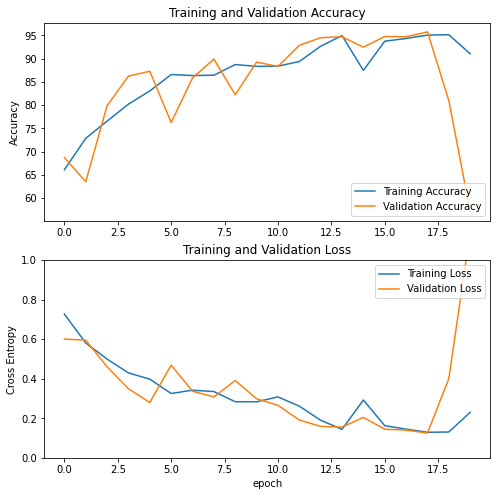

In [8]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()